
   
# Casus: Voorspellen
*Auteur: S.A. Klop*
    
In deze casus laten we de verschillende manieren zien hoe een tijdreeksmodel kan worden gebruikt om te voorspellen. De casus is opgedeeld in twee delen. In het eerste deel wordt gekeken hoe een tijdreeksmodel kan worden gebruikt om te onderzoeken wat de grondwaterstand mogelijk doet na het uitzetten van een pompstation. Het tweede deel beschrijft een voorspelling voor de langere termijn.

**Inhoudsopgave**

- [Deel I: Uitzetten onttrekking](#Deel-I:-Uitzetten-onttrekking)
    - [Beschikbare data](#Beschikbare-data-voorbeeld-1)
    - [Voorbewerken reeksen](#Voorbewerken-reeksen-voorbeeld-1)
    - [Opstellen van het tijdreeksmodel](#Opstellen-van-het-tijdreeksmodel)
    - [Voorspellen van de stijghoogte](#Voorspellen-van-de-stijghoogte)
    - [Controle voorspelling](#Controle-voorspelling)
   
- [Deel II: Herstel van de stijghoogte](#Deel-II:-Herstel-stijghoogte-in-april)
    - [Beschikbare gegevens](#Beschikbare-data-voorbeeld-2)
    - [Opzetten tijdreeksmodel](#Opzetten-tijdreeksmodel)
    - [Voorspelling neerslagoverschot](#Voorspelling-neerslagoverschot)
    - [Voorspellen stijghoogte](#Voorspellen-stijghoogte)


In [1]:
# inladen van de benodigde python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML
import datetime

import pastas as ps

%matplotlib inline
ps.set_log_level("ERROR")

%config InlineBackend.figure_format = 'retina'

## Deel I: Uitzetten onttrekking

Het waterschap heeft de stijghoogte gemeten in Peilbuis 1. In de omgeving van de peilbuis bevindt zich een onttrekking. Vanaf 1 augustus 2012 de onttrekking uitgezet en is het onttrokken debiet teruggeschroefd naar 0 m3/d. Aan een adviesbureau is gevraagd om te bepalen wat de verwachte stijging is van de stijghoogte ter plaatse van peilbuis 1 als gevolg van het uitzetten van deze onttrekking. Hierbij zijn gegevens beschikbaar tot 31 juli 2012.

### Beschikbare data voorbeeld 1
De gemeten stijghoogte is te zien in de onderstaande afbeelding. De meetperiode is van 1995 tot en met 2020. De meetreeks bevat enkele waarden die niet in de reeks passen. Daarom is het nodig om de meetreeks voor te bewerken voordat het in het tijdreeksmodel kan worden toegepast.


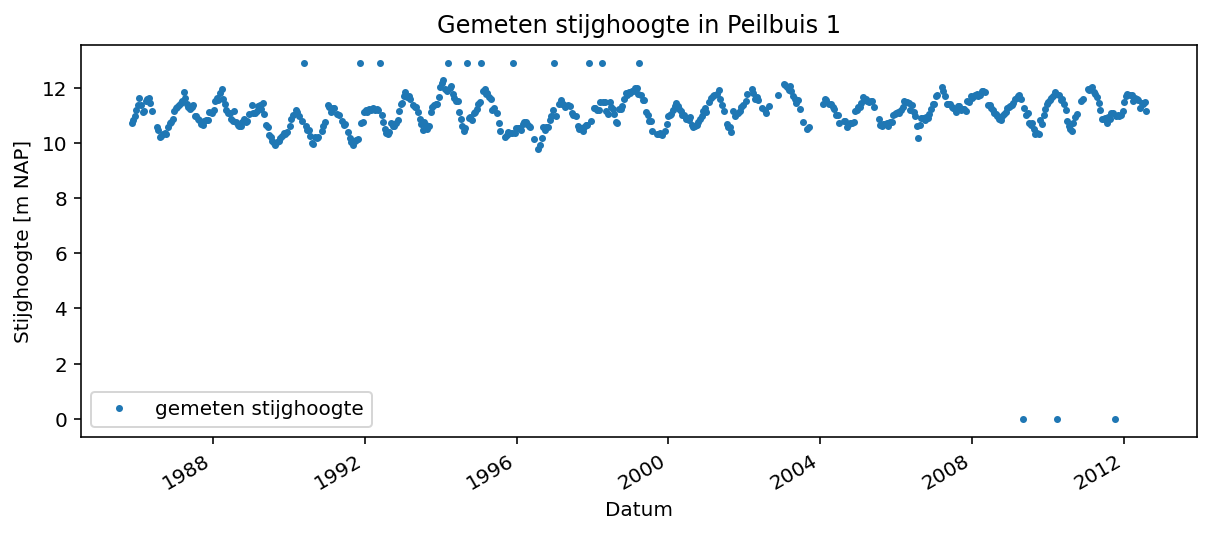

In [2]:
gws = pd.read_csv("data/stijghoogte_onttrekking_edit.csv",
                  index_col=0, parse_dates=True, squeeze=True)

# plotten van de stijghoogte
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
gws[:'2012-08-01'].plot(ax=ax, color='C0', ls='', marker='.', markersize=5)

# opmaken van de figuur
ax.set_ylabel('Stijghoogte [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten stijghoogte in Peilbuis 1')
ax.legend([f'gemeten stijghoogte']);

Om een tijdreeksmodel op te stellen voor stijghoogte meetreeks wordt gebruik gemaakt van de neerslag en verdamping 1. Hiervoor zijn de gegevens gebruikt van het dichtstbijzijnde weerstation van het KNMI. De gemeten neerslag en verdamping zijn te zien in de onderstaande afbeelding.

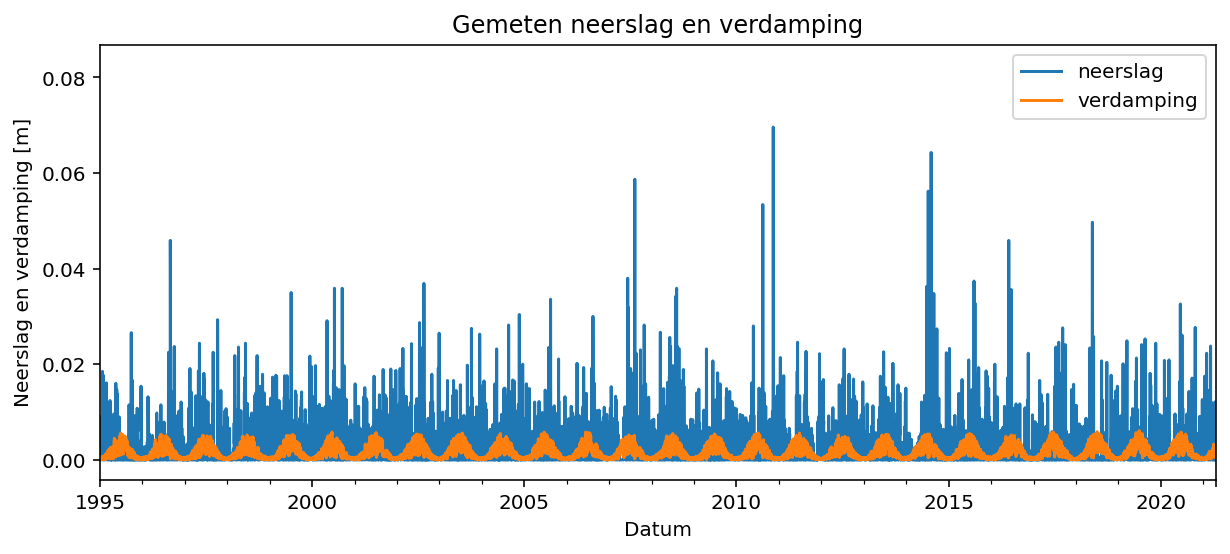

In [3]:
neerslag = pd.read_csv("data/neerslag_onttrekking.csv",
                       index_col=0, parse_dates=True)
neerslag.columns = ['neerslag']
verdamping = pd.read_csv("data/verdamping_onttrekking.csv",
                         index_col=0, parse_dates=True)
verdamping.columns = ['verdamping']

# plotten van de neerslag en verdamping
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
neerslag.plot(ax=ax, color='C0')
verdamping.plot(ax=ax, color='C1')

# opmaken van de figuur
ax.set_ylabel('Neerslag en verdamping [m]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten neerslag en verdamping')
ax.legend([f'neerslag',
          f'verdamping'])
ax.set_xlim(xmin='1995');

Naast de neerslag en verdamping is ook de data van de onttrekking gebruikt als verklarende reeks in het tijdreeksmodel. Hiervoor is bij de beheerder van de onttrekking het dagelijkse debiet opgevraagd. Deze is te zien in de afbeelding hieronder. Hierin is ook te zien dat de onttrekking in 2012 volledig is afgeschaald. In de periode hiervoor varieerde het debiet van de onttrekking tussen de circa 5.000 - 12.000 m$^3$/d

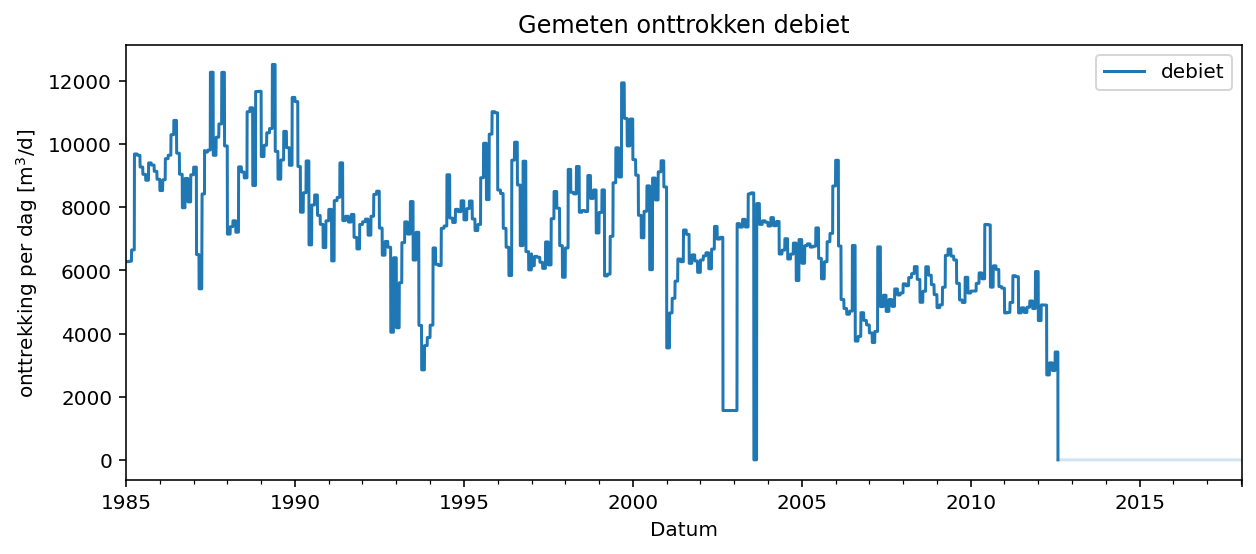

In [4]:
onttrekking = pd.read_csv("data/debiet_onttrekking.csv",
                          index_col="Date", parse_dates=True)  # / 1e6

# plotten van de neerslag en verdamping
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
onttrekking[:'2012-08-01'].plot(ax=ax, color='C0')
onttrekking['2012-08-01':].plot(ax=ax, color='C0', alpha=0.2)

# opmaken van de figuur
ax.set_ylabel('onttrekking per dag [m$^3$/d]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten onttrokken debiet')
ax.legend([f'debiet']);

### Voorbewerken reeksen voorbeeld 1
Zoals te zien in de stijghoogtemeetreeks bevat de meetreeks een aantal 0 waardes. Deze waardes zijn mogelijk het gevolg van een meetfout van de sensor of het uitlezen van de sensor. Om de reeks bruikbaar te maken voor tijdreeksanalyse moet de meetreeks worden voorbewerkt.

De metingen met een waarde van 0 worden verwijderd uit de reeks om deze te gebruiken in het tijdreeksmodel. Hierbij worden de gaten in de reeks niet opgevuld maar leeg gelaten.


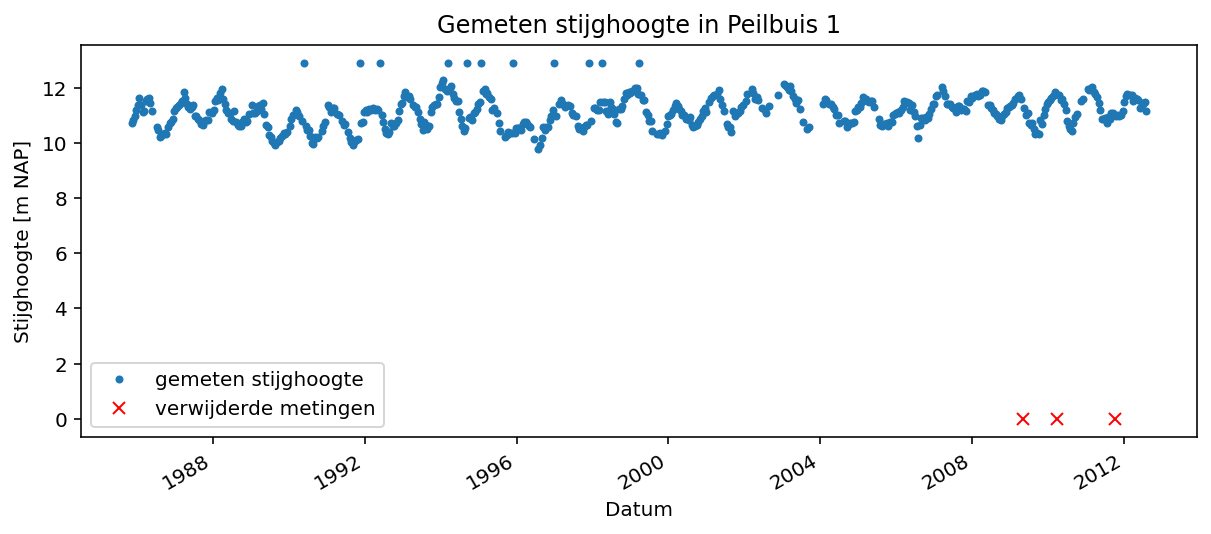

In [5]:
# verwijderde waarden opslaan
gws_del = gws[gws == 0]

# metingen met waarde 0 uit reeks halen
gws_n = gws[gws != 0]

# plotten van de stijghoogte
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
gws_n[:'2012-08-01'].plot(ax=ax, color='C0', ls='', marker='.')
gws_del[:'2012-08-01'].plot(ax=ax, color='red', ls='',
                            marker='x', label='verwijderde waardes')

# opmaken van de figuur
ax.set_ylabel('Stijghoogte [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten stijghoogte in Peilbuis 1')
ax.legend(['gemeten stijghoogte', 'verwijderde metingen']);

### Opstellen van het tijdreeksmodel

De eerste stap voor het opstellen van het model is het toevoegen van de stijghoogte observaties aan het model. Voor een eerste berekening wordt de stijghoogtereeks gebruikt tot aan de huidige datum. 

De neerslag en verdamping worden gebruikt als verklarende reeksen. Voor de verklarende reeksen wordt een respons gekozen. De respons functie beschrijft de reactie van de stijghoogte op een externe invloed. Deze moet worden vastgesteld voor elke verklarende reeks, waarbij de gebruiker het type respons functie kiest en waarbij de parameters van deze functie worden geoptimaliseerd. Voor het tijdreeksmodel wordt gekozen voor de Gamma respons functie voor de neerslag en verdamping. 

In het tijdreeksmodel wordt dezelfde responsfunctie gebruikt voor de neerslag en de verdamping. Hierbij wordt het verband tussen de neerslag en verdamping beschreven met de formule $R=P−f \cdot E$, waarbij R de grondwateraanvulling is [m], P de neerslag [m], f de verdampingsfactor [-] en E de verdamping [m]. De verdampingsfactor wordt door het tijdreeksmodel geoptimaliseerd samen met de drie parameters van de Gamma responsfunctie.

De onttrekking wordt als verklarende reeks gebruikt in het tijdreeksmodel. Voor deze verklarende reeks wordt de Hantush responsfunctie gekozen. Naast de verklarende reeksen wordt ook de constante (in het tijdreeksmodel d) geoptimaliseerd in het model.

Na het toevoegen van de observaties en de verklarende reeksen kan het tijdreeksmodel worden geoptimaliseerd. De resultaten van het tijdreeksmodel zijn te zien in de onderstaande tabel.



In [6]:
# opzetten model
ml = ps.Model(gws_n[:'2012-08-01'])

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.RechargeModel(neerslag, verdamping, rfunc=ps.Gamma, name='gwa')

# toevoegen van onttrekking als verklarende reeks
sm2 = ps.StressModel(stress=onttrekking, rfunc=ps.Hantush,
                     name='onttrekking', settings='well', up=False)
ml.add_stressmodel([sm1, sm2])

# oplossen van het tijdreeksmodel
ml.solve(report=False)

# simuleren van de stijghoogte
gws_simulatie1 = ml.simulate()

Als het tijdreeksmodel is geoptimaliseerd kan de gesimuleerde reeks worden geplot. Dit is te zien in de onderstaande afbeelding samen met een overzicht van de modelresultaten.

In de figuur zijn de metingen en de simulatie visueel weergeven. Daaronder zijn de model residuen en ruis weergeven. Voor de verschillende verklarende reeksen zijn de bijdrages te zien samen met de respons functies van deze reeksen. Dit zijn de Gamma response functies zoals geoptimaliseerd door het tijdreeksmodel. Daarnaast is aan de figuur een tabel toegevoegd met daarin de geoptimaliseerde parameters met de bijbehorende standaarddeviaties. Hierin zijn bijvoorbeeld ook de geoptimaliseerde constante en verdampingsfactor weergeven.


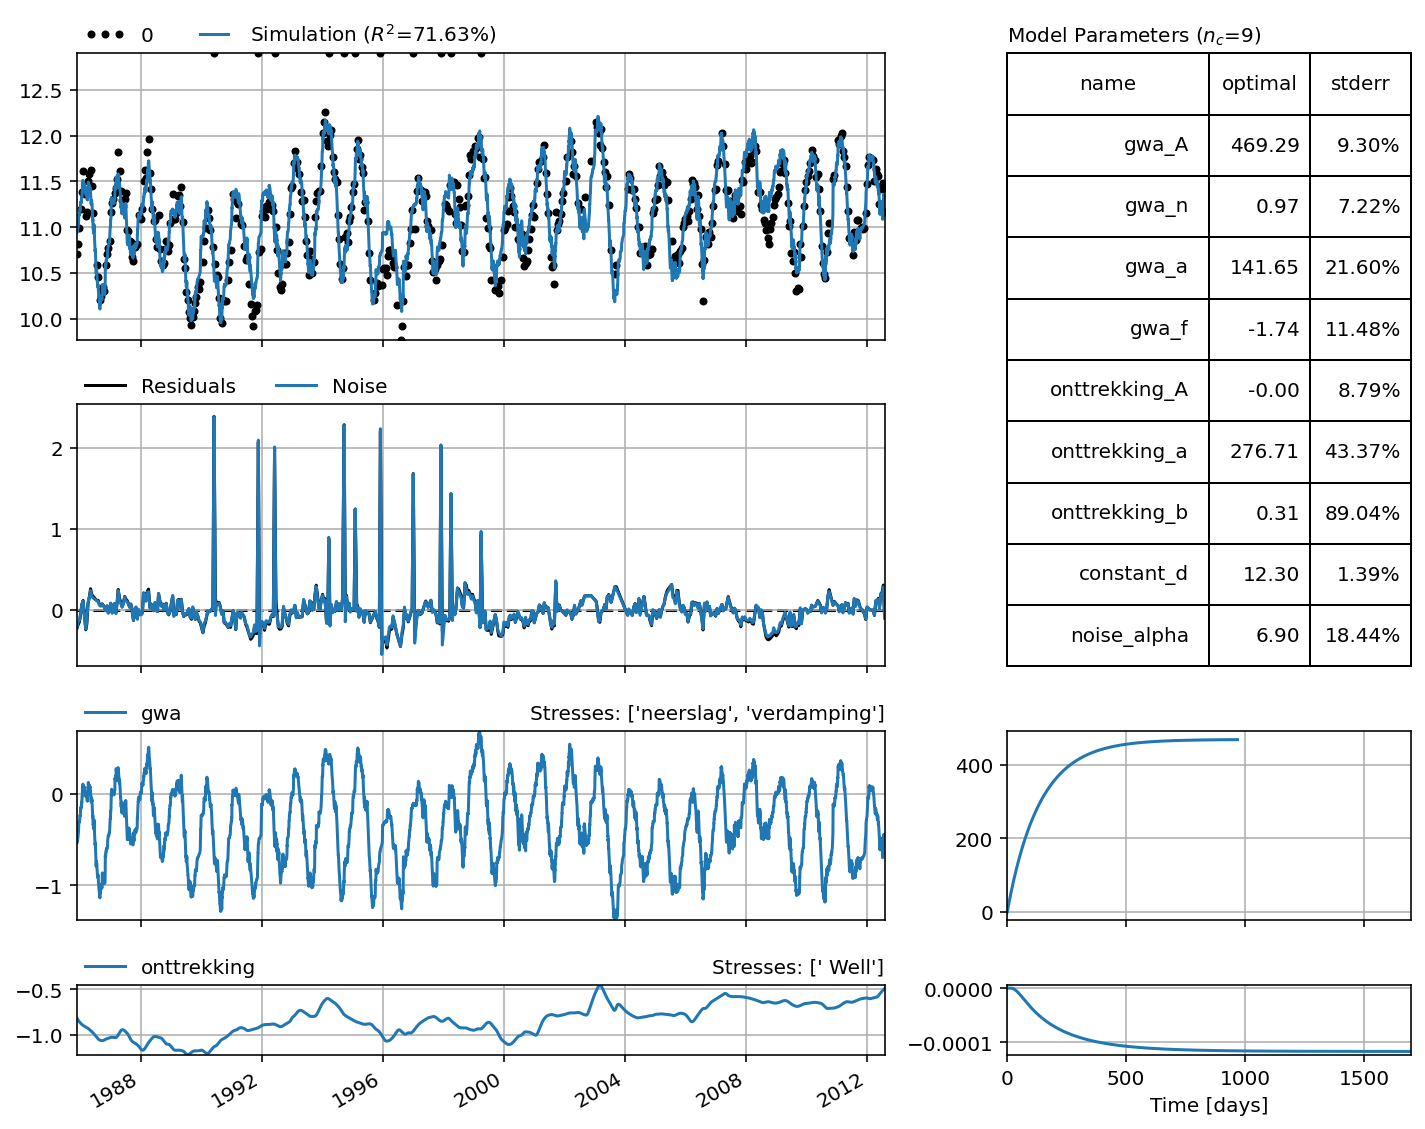

In [7]:
ml.plots.results(figsize=(10, 8));

In de resultaten van het model valt op dat het tijdreeksmodel niet in staat is om de uitschieters in de meetreeks correct te simuleren. Na overleg met de beheerder van het gebied waar Peilbuis 1 in staat blijkt dat de metingen boven de +12.8 m NAP onrealistisch zijn, deze komen niet overeen met de observaties in het veld. Mogelijk is de peilbuis gedurende deze dagen volgelopen waardoor hogere waardes zijn geregistreerd.

Deze uitschieters kunnen het tijdreeksmodel mogelijk negatief beïnvloeden omdat deze metingen niet verklaard kunnen worden met behulp van de verklarende reeksen die worden gebruikt. Daarom wordt het tijdreeksmodel opnieuw gemaakt maar worden nu enkel stijghoogte meegenomen van < +12.8 m NAP.


In [8]:
# opzetten model met enkel metingen van onder mv
mv = 12.8
ml2 = ps.Model(gws_n[gws_n < mv][:'2012-08-01'])

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.RechargeModel(neerslag, verdamping, rfunc=ps.Gamma, name='gwa')

# toevoegen van onttrekking als verklarende reeks
sm2 = ps.StressModel(stress=onttrekking, rfunc=ps.Hantush,
                     name='onttrekking', settings='well', up=False)
ml2.add_stressmodel([sm1, sm2])

# oplossen van het tijdreeksmodel
ml2.solve(report=False)

# simuleren van de stijghoogte
gws_simulatie2 = ml2.simulate()

De resultaten van het nieuwe tijdreeksmodel zijn te zien in de onderstaande afbeelding.



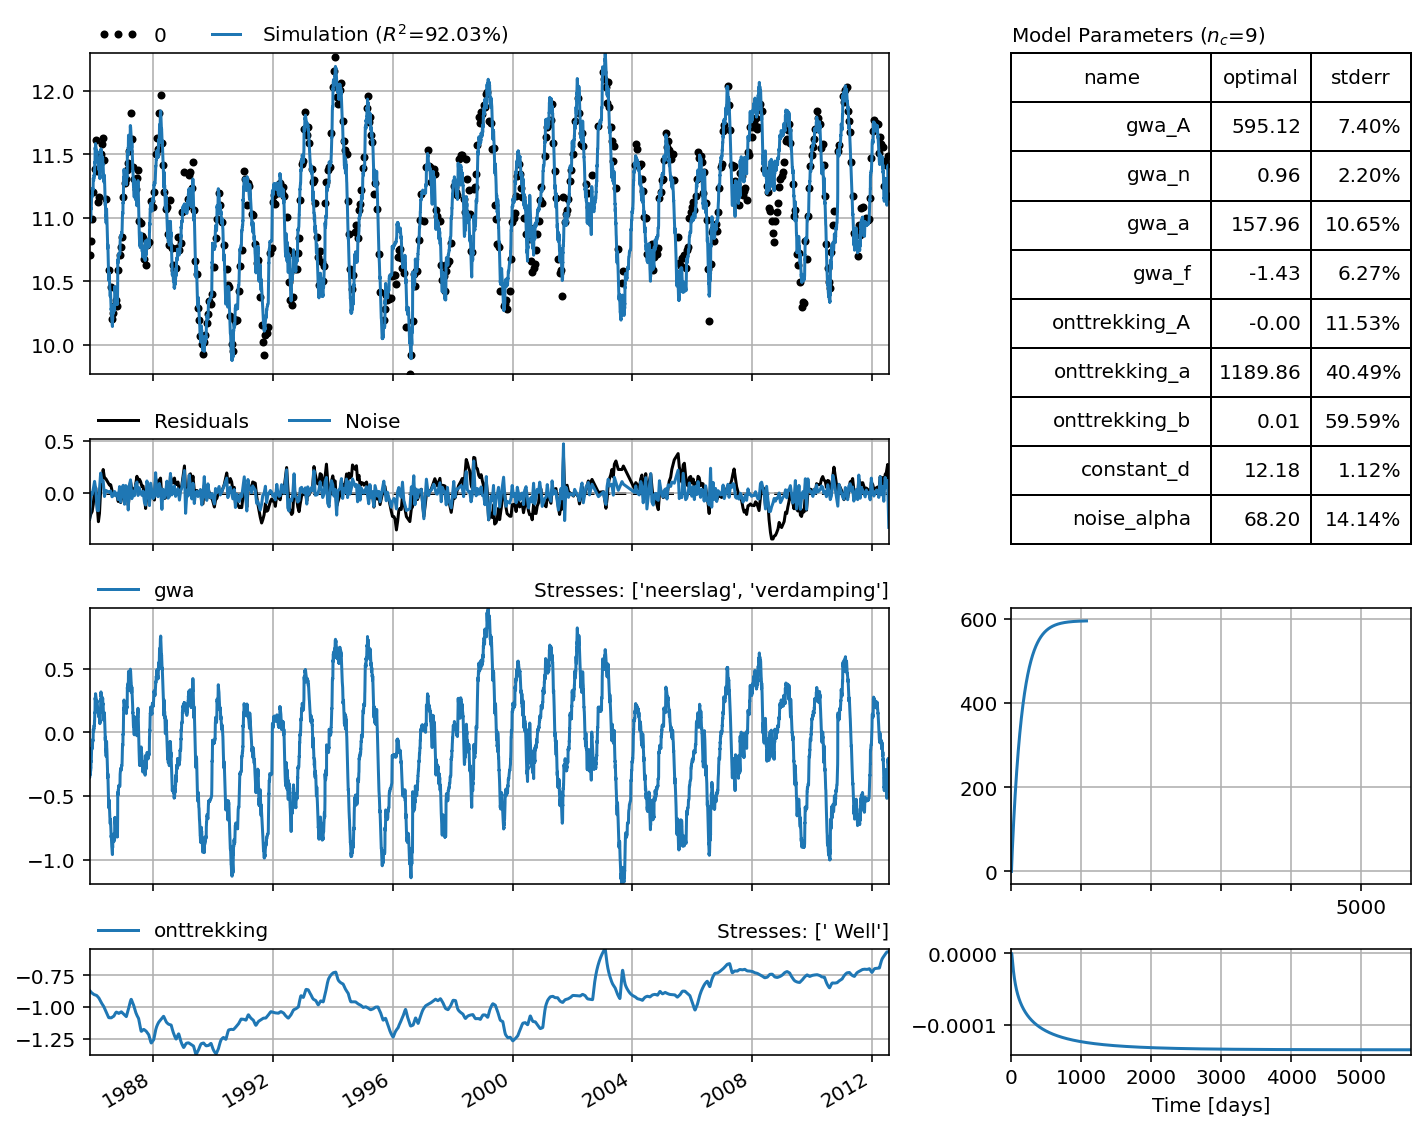

In [9]:
ml2.plots.results(figsize=(10, 8));

Het tweede tijdreeksmodel, waarbij de metingen van > 17 m NAP niet zijn meegenomen, heeft een hogere verklaarde variantie en R2 , en een lagere root mean square error (RMSE). In de onderstaande afbeelding is de gesimuleerde stijghoogtereeks van het nieuwe tijdreeksmodel (zonder uitbijters en onrealistische metingen) vergeleken met het eerste tijdreeksmodel. Hierbij is te zien dat op basis van een visuele inspectie niet te zien is welk tijdreeksmodel beter presteert, op het oog is het een vergelijkbare prestatie.

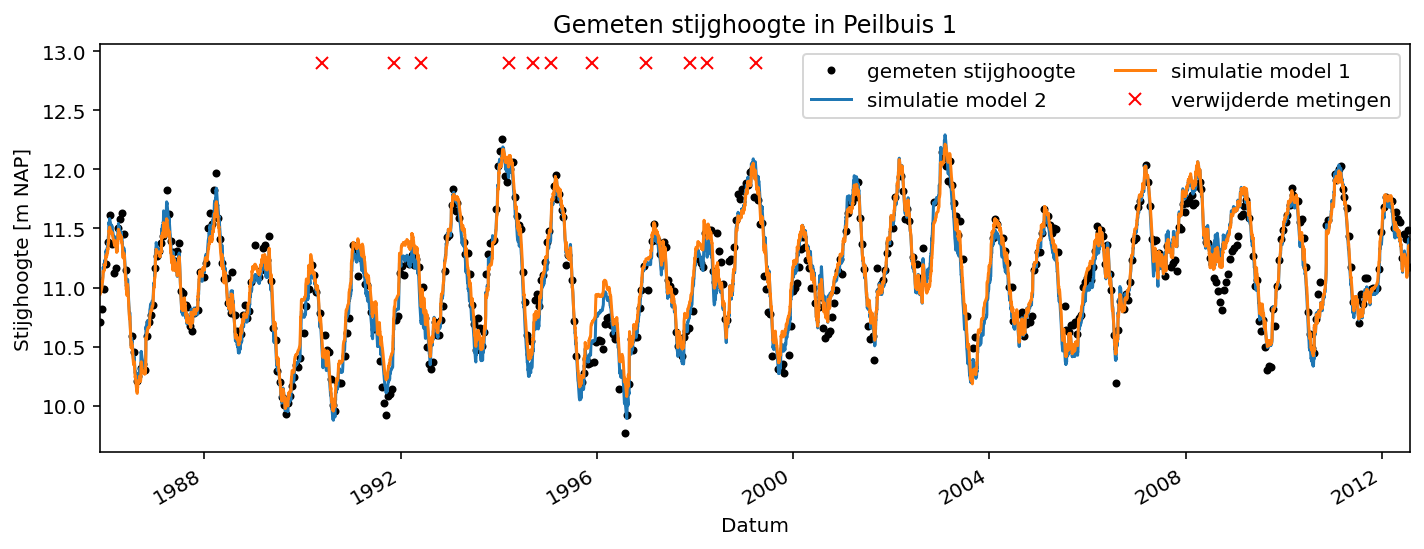

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ml2.plot(ax=ax)
gws_simulatie1.plot(ax=ax)

# verdijderde metingen aangeven
ax.plot(gws_n[gws_n > mv], marker='x', ls='', color='r')

# opmaken van de figuur
ax.set_ylabel('Stijghoogte [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten stijghoogte in Peilbuis 1')
ax.legend(['gemeten stijghoogte', 'simulatie model 2',
           'simulatie model 1', 'verwijderde metingen'], ncol=2);

In eerste instantie zijn voor de verklarende reeksen de Gamma en Hantush respons functies gekozen. Het is aan de modelleur om de keuze voor de respons functie te maken. Daarom wordt het model nogmaals opgesteld met verschillende respons functies om deze te vergelijken. Hierbij wordt voor beide verklarende reeksen de volgende respons functies gebruikt: Exponentieel, Gamma en de Hantush respons.

In de onderstaande tabellen zijn de R$^2$ en RMSE van de modellen weergeven. Langs de rijen van de tabellen staat de respons functie van de neerslag en verdamping en langs de kolommen de respons functie van de onttrekking.


In [11]:
R2_df = pd.DataFrame()
RMSE_df = pd.DataFrame()

for res_precevap in [ps.Exponential, ps.Gamma, ps.FourParam]:
    for res_onttreking in [ps.Exponential, ps.Gamma, ps.Hantush]:
        ml2 = ps.Model(gws_n.loc[gws_n < mv].loc[:'2012-08-01'])

        # toevoegen van neerslag en verdamping als verklarende reeksen
        sm1 = ps.RechargeModel(neerslag, verdamping,
                               rfunc=res_precevap, name='gwa')

        # toevoegen van onttrekking als verklarende reeks
        sm2 = ps.StressModel(stress=onttrekking, rfunc=res_onttreking,
                             name='onttrekking', settings='well', up=False)
        ml2.add_stressmodel([sm1, sm2])

        # oplossen van het tijdreeksmodel
        ml2.solve(report=False)
        r = str(res_precevap).split('.')[-1][:-2]
        c = str(res_onttreking).split('.')[-1][:-2]
        R2_df.loc[r, c] = ml2.stats.rsq()
        RMSE_df.loc[r, c] = ml2.stats.rmse()

# opmaken tabellen
R2_df_new = pd.concat(
    [R2_df], keys=['respons onttrekking'], names=[' '], axis=1)
R2_df_new.index.name = 'respons grondwateraanvulling'

print('Model R\u00b2')
display(R2_df_new.round(2))

# opmaken tabellen
RMSE_df_new = pd.concat(
    [RMSE_df], keys=['respons onttrekking'], names=[' '], axis=1)
RMSE_df_new.index.name = 'respons grondwateraanvulling'

print('Model RMSE')
display(RMSE_df_new.round(2))

Model R²


respons onttrekking              
                                     Exponential Gamma Hantush
respons grondwateraanvulling                                  
Exponential                                 0.92  0.92    0.92
Gamma                                       0.92  0.92    0.92
FourParam                                   0.92  0.92    0.92

Model RMSE


respons onttrekking              
                                     Exponential Gamma Hantush
respons grondwateraanvulling                                  
Exponential                                 0.14  0.14    0.14
Gamma                                       0.14  0.14    0.14
FourParam                                   0.14  0.14    0.14

Zoals te zien in de tabellen zijn er verschillende combinaties voor de respons functies die gelijkwaardige model prestaties geven. Te zien is dat het model de hoogste R$^2$ en laagste RMSE heeft wanneer voor de respons van de grondwateraanvulling de Gamma respons wordt gekozen. De keuze van de respons voor de onttrekking is minder van invloed op de modelresultaten. 

Er wordt gekozen om de eerdere keuze voor de Gamma respons voor de grondwateraanvulling en de Hantush respons voor de 


In [12]:
# opzetten model met enkel metingen van < 12.8 m NAP
ml2 = ps.Model(gws_n[gws_n < mv][:'2012-08-01'])

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.RechargeModel(neerslag, verdamping, rfunc=ps.Gamma, name='gwa')

# toevoegen van onttrekking als verklarende reeks
sm2 = ps.StressModel(stress=onttrekking, rfunc=ps.Hantush,
                     name='onttrekking', settings='well', up=False)
ml2.add_stressmodel([sm1, sm2])

# oplossen van het tijdreeksmodel
ml2.solve(report=False)

# simuleren van de stijghoogte
ml2_sim = ml2.simulate(tmax='2018-01-12')

### toetsen van het tijdreeksmodel

Voor het maken van een voorspelling is het nodig iets te zeggen over de onzekerheid van het tijdreeksmodel, uitgedrukt in de standaarddeviatie van de modelparameters. Om dit te doen moet worden gecontroleerd of de resultaten van het tijdreeksmodel voldoende zijn om de onzekerheid goed in te kunnen schatten. 

Bij het bepalen van de onzekerheid van de modelparameters is de aanname dat de ruis van het model zogenaamde "witte ruis" is. Hiervoor worden vier aannames gecontroleerd:

- het gemiddelde van de ruis is nul;
- de waardes zijn onafhankelijk van elkaar;
- De ruis is normaal verdeeld;
- De ruis heeft een constante variantie.

Als de ruis aan deze toetsen voldoet mag aangenomen worden dat de ruis "witte ruis" betreft en dat de standaard deviatie van de modelparameters juist is ingeschat.

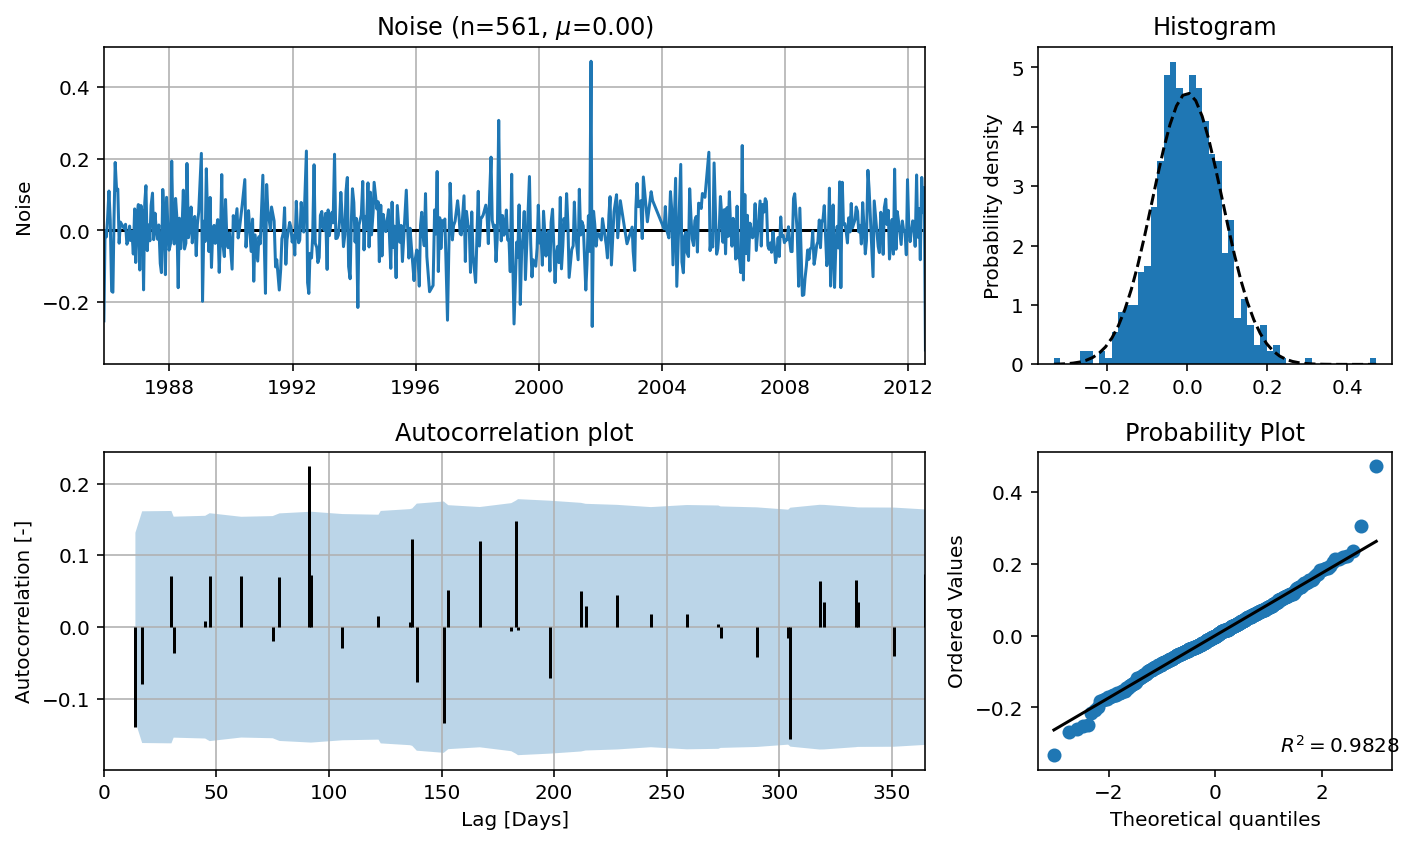

In [13]:
ml2.plots.diagnostics();

In de figuur linksboven is de ruis weergeven. Te zien is dat er geen duidelijke trend zichtbaar is en dat de gemiddelde waarde ($\mu$) gelijk is aan 0,00. In de figuur linksonder is de autocorrelatie van de lag weergeven met het bijbehorende 95% zekerheidsinterval. Hiervoor geldt dat 95% vaan de autocorrelatie waardes binnen dit interval moeten liggen. Zoals te zien in deze plot geldt dit voor de huidige reeks met ruis. 

De figuur rechtsboven weergeeft de ruis als verdeling, met een bijbehorende normale verdeling, gefit op de ruis. Deze figuur kan worden gebruikt om te kijken of de ruis aan een normale verdeling voldoet. De figuur rechtsonder kan ook worden gebruikt om de normaliteit te toetsen. In dit geval voldoet de ruis goed aan de eis van de normale verdeling


### Voorspellen van de stijghoogte

Nu het tijdreeksmodel is opgesteld kan het gebruikt worden om het effect van het afbouwen van de onttrekking te voorspellen.

Hiervoor wordt gekeken naar de respons functie van de onttrekking. Deze is weergegeven in de onderstaande afbeelding. Hierbij is ook de bandbreedte van de respons functie te zien met een 95% zekerheidsinterval. Deze is bepaald met behulp van een Monte Carlo Sampling op basis van de resultaten van de tijdreeksanalyse. De respons functie stabiliseert na bijna 6000 dagen. De "gain" (niveau waarop de respons functie stabiliseert) van de respons functie is gelijk aan circa -0.00014 m (-0.14 mm), de verlaging die optreedt ten gevolge van permanente een onttrekking van 1 m3/d. Voor een constante onttrekking van bijvoorbeeld 1000 m$^3$/d zou de stijghoogte naar verwachting 0.14 meter dalen.


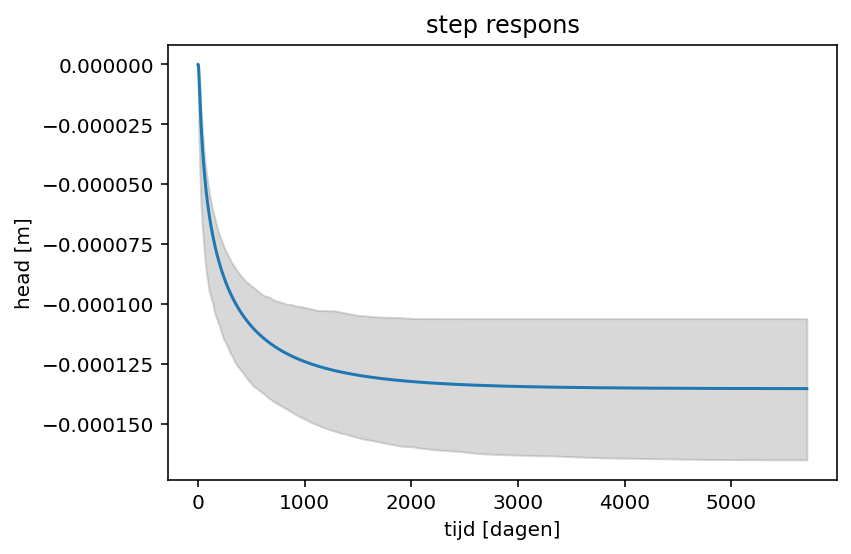

In [14]:
fig, ax = plt.subplots()
step = ml2.get_step_response('onttrekking')
ci_step = ml2.fit.ci_step_response('onttrekking')
ax.plot(step)
ax.fill_between(x=ci_step.index,
                y1=ci_step[0.025], y2=ci_step[0.975], color='gray', alpha=0.3)

# figuur opmaken
ax.set_xlabel('tijd [dagen]')
ax.set_ylabel('head [m]')
ax.set_title('step respons');

Met behulp van deze responsfunctie kan de verwachte stijging van de stijghoogte ten gevolge van het uitzetten van de onttrekking worden voorspeld. De gemiddelde onttrekking voor de periode tot 2012-08-01 bedraagt 7171 m3/d. De respons ten gevolge van de verandering van gemiddeld 7171 m$^3$/d naar 0 m$^3$/d is te zien in de onderstaande afbeelding, hierbij is de respons, zoals deze is bepaald door middel van het tijdreeksmodel, geschaald naar de gemiddelde onttrekking. De gemiddelde verwachte stijging is tussen de 0.75 en 1.18 meter, waarbij het effect van de onttrekking na 5700 dagen is uitgedempt.

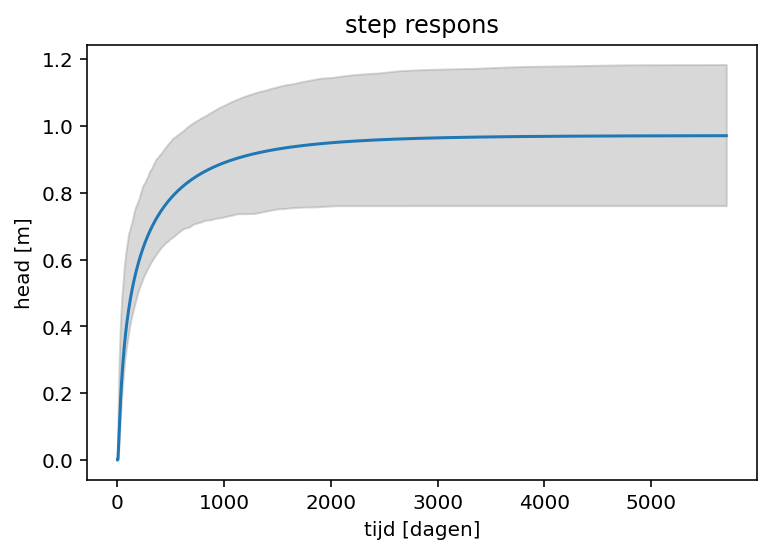

In [15]:
fig, ax = plt.subplots()

gem_onttrekking = onttrekking[onttrekking != 0].mean().values

ax.plot(step * - gem_onttrekking)
ax.fill_between(x=ci_step.index, y1=ci_step[0.025] * -gem_onttrekking,
                y2=ci_step[0.975] * -gem_onttrekking, color='gray', alpha=0.3)
verwachting = step.iloc[-1] * -gem_onttrekking
bovengrens = ci_step[0.025].iloc[-1] * -gem_onttrekking
ondergrens = ci_step[0.975].iloc[-1] * -gem_onttrekking
# print(bovengrens, ondergrens)

# figuur opmaken
ax.set_xlabel('tijd [dagen]')
ax.set_ylabel('head [m]')
ax.set_title('step respons');

### Controle voorspelling

Een aantal jaar later besluit het waterschap te kijken of de voorspelling van het adviesbureau voor de stijghoogte is uitgekomen. Hierbij worden de meeste recente metingen van de grondwaterstand gebruikt. De volledige reeks is te zien in de onderstaande afbeelding. Hierin is te zien dat de grondwaterstand sinds 2012 lijkt te zijn toegenomen.

In de afbeelding is daarnaast de simulatie te zien waarbij de meeste recente data is gebruikt voor de neerslag en verdamping. Hiervoor is hetzelfde tijdreeksmodel gebruikt zoals deze is opgesteld voor het uitvoeren van de voorspelling.


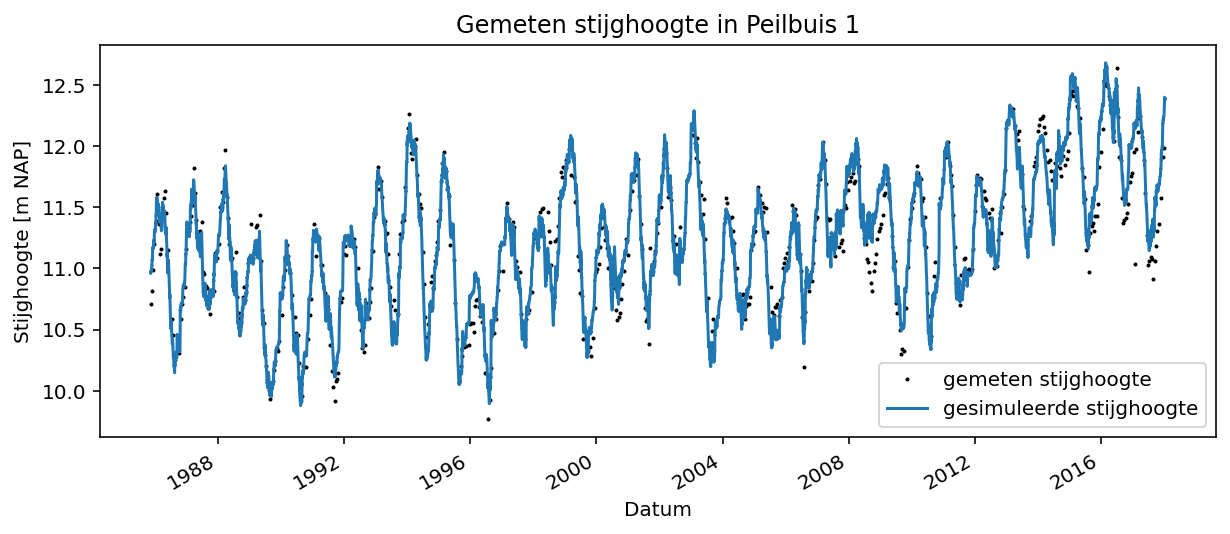

In [16]:
# plotten van de stijghoogte
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
gws_n[gws_n < mv].plot(ax=ax, color='k', ls='', marker='.', markersize=2)
ml2_sim.plot(ax=ax, color='C0')

# opmaken van de figuur
ax.set_ylabel('Stijghoogte [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten stijghoogte in Peilbuis 1')
ax.legend([f'gemeten stijghoogte', 'gesimuleerde stijghoogte']);

Er wordt een nieuw tijdreeksmodel opgesteld met de meest recente data. De meetreeksen voor de neerslag en verdamping en de onttrekking zijn aangevuld. Voor de verklarende reeksen worden dezelfde respons functies gekozen zoals in de vorige analyse.

In [17]:
ml2 = ps.Model(gws_n[gws_n < mv])

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.RechargeModel(neerslag, verdamping, rfunc=ps.Gamma, name='gwa')

# toevoegen van onttrekking als verklarende reeks
sm2 = ps.StressModel(stress=onttrekking, rfunc=ps.Hantush,
                     name='onttrekking', settings='well', up=False)
ml2.add_stressmodel([sm1, sm2])

# oplossen van het tijdreeksmodel
ml2.solve(report=False)

De simulatie van het tijdreeksmodel met de volledige meetreeks is te zien in de onderstaande afbeelding. Daarnaast zijn de bijdrages van de verschillende verklarende reeksen te zien. Voor de onttrekking is te zien dat de bijdrage van deze verklarende reeks afneemt na 2012 (wanneer de onttrekking wordt uitgezet). Hierbij is ook duidelijk te zien dat het effect hiervan langzaam uitdempt en niet instantaan optreedt.

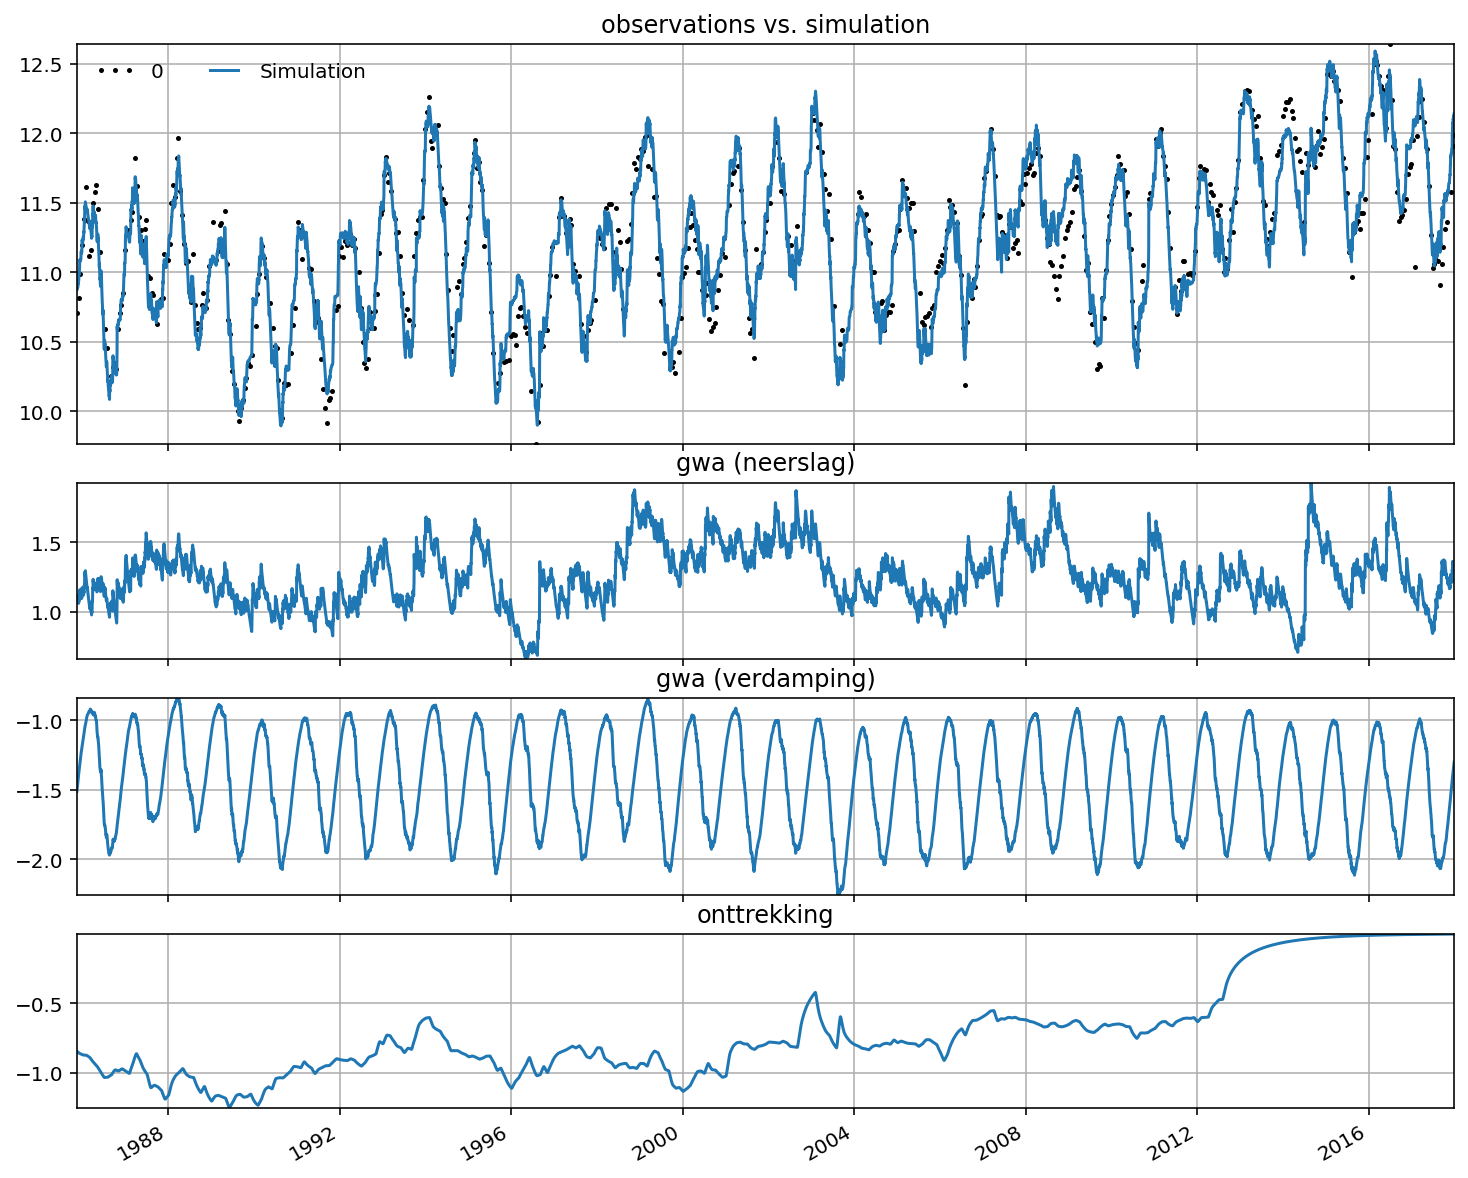

In [18]:
ml2.plots.decomposition(figsize=(10, 8));

De step responses van beide modellen zijn weergeven in de onderstaande afbeelding. Hierin is te zien dat de respons functies verschillen. Met de nieuwe respons functie ligt de bandbreedte van het gemiddelde effect van het uitzetten van de onttrekking tussen de 0.76 en 0.93 meter tegenover de bandbreedte tussen de 0.75 en 1.18 meter van het oude tijdreeksmodel (voor een onttrekking van 7171 m$^3$/d). Daarnaast zal volgens het nieuwe tijdreeksmodel het effect van de onttrekking ook sneller uitdempen. 

In de onderstaande figuur is te zien dat de respons zoals bepaald met het nieuwe tijdreeksmodel binnen de bepaalde bandbreedte van het oude tijdreeksmodel valt. De bandbreedte van de nieuwe respons valt ook binnen de bandbreedte van het oude tijdreeksmodel. 

Uit deze resultaten blijkt dat de voorspelling van de verhoging ten gevolge van het uitzetten van de onttrekking past bij de huidige metingen. Met het nieuwe tijdreeksmodel is de onzekerheid van de respons verkleind.

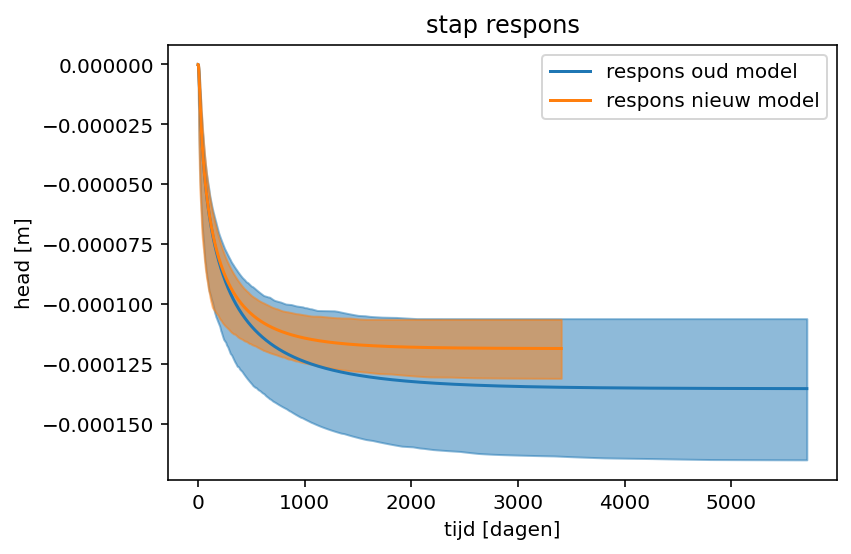

In [19]:
fig, ax = plt.subplots()

step_new = ml2.get_step_response('onttrekking')
ci_step_new = ml2.fit.ci_step_response('onttrekking')

ax.plot(step)
ax.plot(step_new)
ax.fill_between(x=ci_step.index,
                y1=ci_step[0.025], y2=ci_step[0.975], color='C0', alpha=0.5)
ax.fill_between(x=ci_step_new.index,
                y1=ci_step_new[0.025], y2=ci_step_new[0.975], color='C1', alpha=0.5)

verwachting_new = step_new.iloc[-1] * gem_onttrekking
ondergrens_new = ci_step_new[0.025].iloc[-1] * -gem_onttrekking
bovengrens_new = ci_step_new[0.975].iloc[-1] * -gem_onttrekking

# figuur opmaken
ax.set_xlabel('tijd [dagen]')
ax.set_ylabel('head [m]')
ax.set_title('stap respons')
ax.legend(['respons oud model', 'respons nieuw model']);

## Deel II: Herstel grondwaterstand in april

In een natuurgebied wordt de grondwaterstand al jaren gemeten in PB01. In de afgelopen jaren (2018 en 2019) merkt het waterschap dat de grondwaterstand in de zomerperiode lager ligt dan gemiddeld. Ook bij de laatste metingen in augustus 2019 was dit het geval. Aan de hydroloog van het waterschap is gevraagd of een inschatting kan worden gegeven voor de grondwaterstand bij de start van het nieuwe groeiseizoen in april volgend jaar (april 2020). 

Op basis van een tijdreeksanalyse wordt gekeken naar de verwachte grondwaterstand ten gevolge van een "natte", "droge" en een "gemiddelde" winterperiode (van september tot april). Zo hoop het waterschap inzicht te krijgen in het herstel van de stijghoogte onder verschillende omstandigheden.


### Beschikbare data voorbeeld 2

In de onderstaande afbeelding is de meetreeks van peilbuis PB01 te zien. De meetreeks loopt van 1985 tot september 2019. De variatie in de grondwaterstand is ca. 2 meter. In de reeks is te zien dat de stijghoogte in de zomer van 2018 en 2019 relatief laag is geweest vanwege de relatief droge periodes.

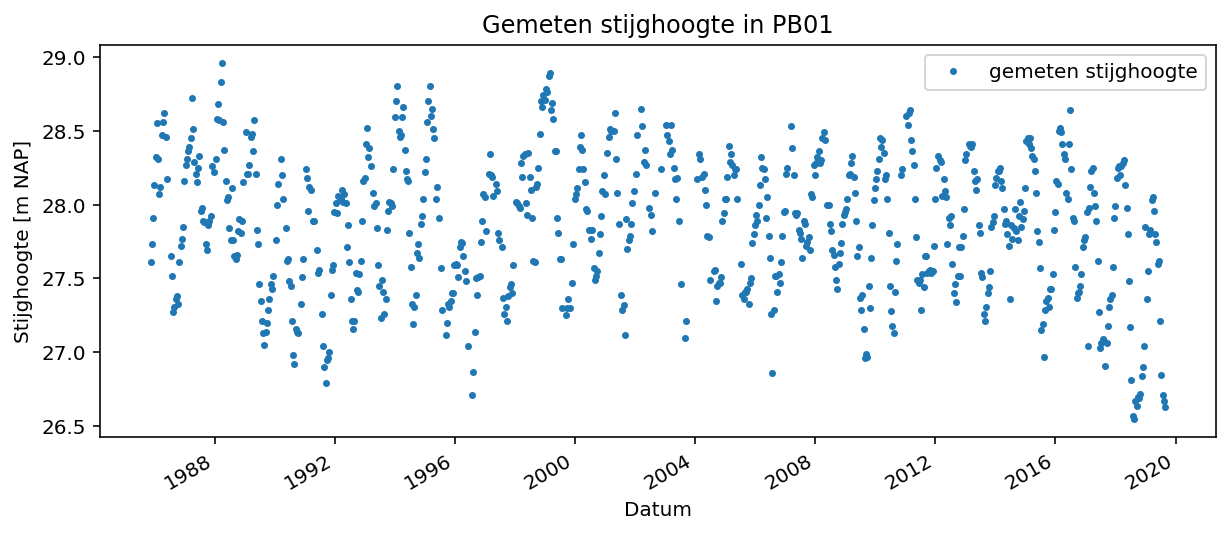

In [20]:
gws = ps.read_dino('data/PB01.csv').series

# plotten van de stijghoogte
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
gws[:'2019-09-01'].plot(ax=ax, color='C0', ls='', marker='.', markersize=5)

# opmaken van de figuur
ax.set_ylabel('Stijghoogte [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten stijghoogte in PB01')
ax.legend([f'gemeten stijghoogte']);

De data voor de neerslag en verdamping nabij PB01 zijn verzameld van het dichtsbijzijnde KNMI weerstation. De neerslag en verdamping zijn weergeven in de onderstaande grafiek. Het weerstation bevat data vanaf 1965 tot en met september 2019. 

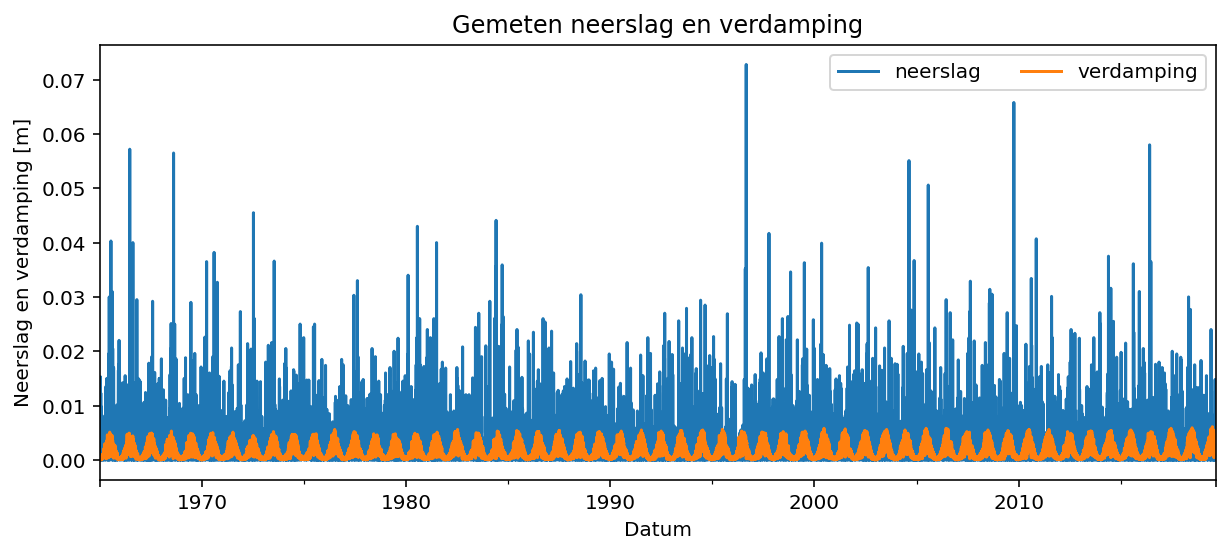

In [21]:
neerslag = pd.read_csv('data/neerslag.csv', index_col=0, parse_dates=True)
verdamping = pd.read_csv('data/verdamping.csv', index_col=0, parse_dates=True)

# plotten van de neerslag en verdamping
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
neerslag[:'2019-09-01'].plot(ax=ax, color='C0')
verdamping[:'2019-09-01'].plot(ax=ax, color='C1')

# opmaken van de figuur
ax.set_ylabel('Neerslag en verdamping [m]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten neerslag en verdamping')
ax.legend(['neerslag', 'verdamping'], ncol=2);

### Opzetten tijdreeksmodel

Er wordt een tijdreeksmodel opgesteld op basis van de meetreeks in PB01. Hiervoor worden de neerslag en verdamping gebruikt als verklarende reeks. Voor de neerslag en verdamping wordt de Gamma respons functie gekozen in de tijdreeksanalyse.


In [22]:
# opzetten model
ml = ps.Model(gws[:'2019-09-01'])

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.RechargeModel(neerslag, verdamping, rfunc=ps.Gamma, name='gwa')
ml.add_stressmodel(sm1)

# oplossen van het tijdreeksmodel
ml.solve(report=False)

Het tijdreeksmodel heeft een R$^2$ van 0.92. In de onderstaande figuur is de simulatie van het tijdreeksmodel te zien samen met de stijghoogte metingen. De variatie in stijghoogte lijkt goed verklaard te kunnen worden met behulp van de neerslag en verdamping. Het tijdreeksmodel is gesimuleerd tot aan 1 september 2019.

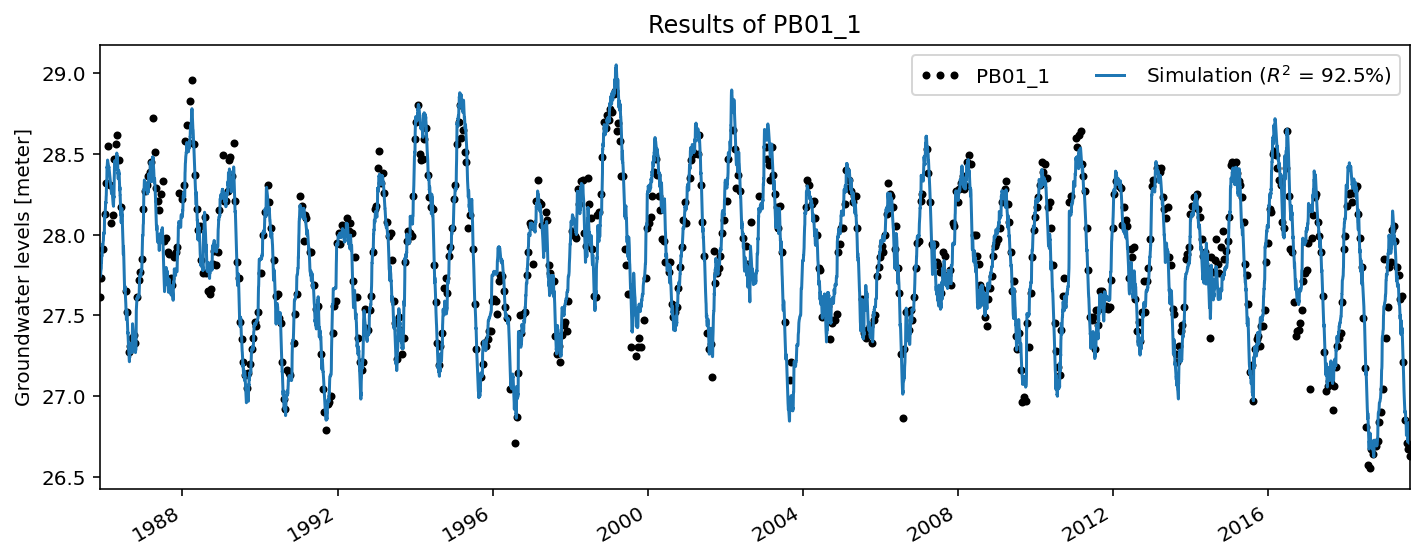

In [23]:
ml.plot(figsize=(10, 4));

### Voorspelling neerslagoverschot
Om een inschatting te maken van de stijghoogte ten gevolge van de "natte", "droge" en "gemiddelde" winterperiode wordt gekeken naar het neerslagoverschot van de afgelopen 30 jaar. 

Het neerslagoverschot wordt berekend op basis van de neerslag, verdamping en de verdampingsfactor. Bij het gebruik van de verdampingsfactor wordt de onzekerheid van deze parameters niet meegenomen in de analyse, de onzekerheid van het bepaalde neerslagoverschot wordt daarom ook niet meegenomen. In de onderstaande afbeeldingen zijn de neerslagoverschotten van de afgelopen 30 jaar weergeven, waarbij de jaren 2018 en 2019 zijn gemarkeerd. De aanname bij het bepalen van deze neerslagoverschotten voor de afgelopen 30 jaar is dat de relatie tussen neerslag, verdamping en grondwateraanvulling niet is verandert en dat deze relatie ook in droge of natte jaren gelijk is gebleven.

In het overzicht valt op dat, voor de periode september - april, het neerslagoverschot in 2018 tot een van de laagste van de afgelopen 30 jaar behoort.

Voor het "natte" jaar wordt de 95% bovengrens van het neerslagoverschot aangehouden. Voor het droge jaar de 5% ondergrens. Het "gemiddelde" jaar wordt op basis van het gemiddelde neerslagoverschot berekend. Deze scenario's zijn berekend op basis van de dagelijkse neerslagoverschotten, per dag is de 95%, 5% of gemiddelde waarde voor het neerslagoverschot bepaald. De bandbreedte die dit oplevert is te zien in de onderstaande afbeelding.

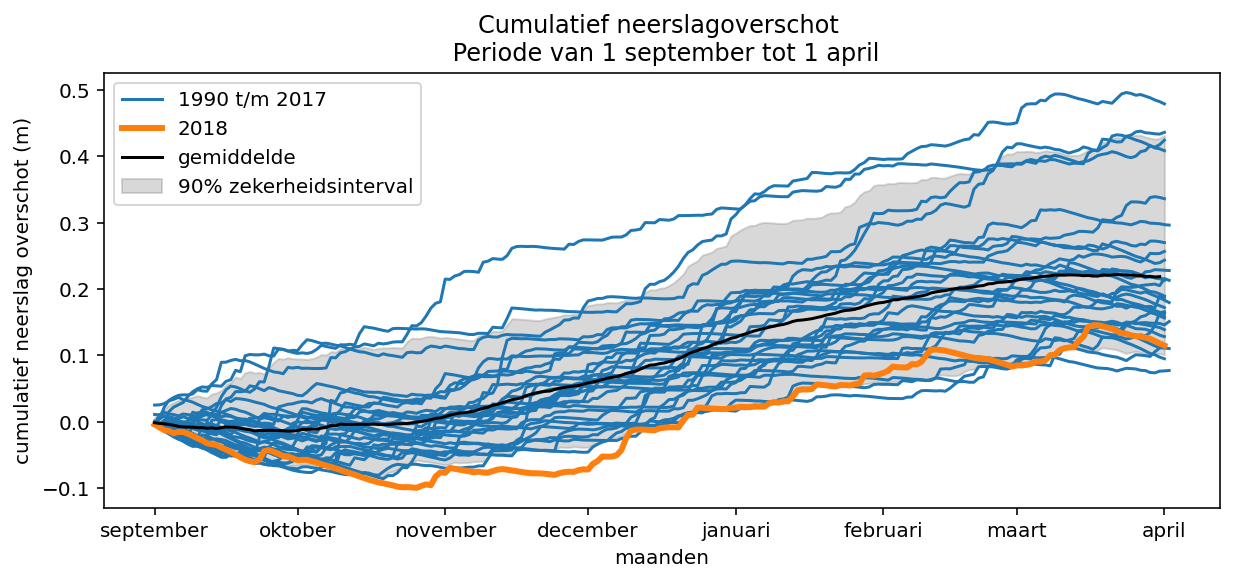

In [24]:
plt.figure(figsize=(10, 4))

overschot = pd.DataFrame()
fac_verdamping = ml.parameters.loc['gwa_f', 'optimal']
for year in range(1990, 2019, 1):
    y = (neerslag[f'{year}-09-01':f'{year+1}-04-01'] +
         fac_verdamping * verdamping[f'{year}-09-01':f'{year+1}-04-01'])
    y = y.cumsum()
    x = np.arange(len(y))

    if year == 1990:
        plt.plot(x, y, color='C0', label='1990 t/m 2017')
        dt_max = y.idxmax() - datetime.datetime(year, 9, 1)
    elif year == 2018:
        plt.plot(x, y, color='C1', label='2018', lw=3)
        dt_max = y.idxmax() - datetime.datetime(year, 9, 1)
    else:
        plt.plot(x, y, color='C0')
        dt_max = y.idxmax() - datetime.datetime(year, 9, 1)
    y.columns = [str(year)]
    y.index = y.index.month.astype(str) + '-' + y.index.day.astype(str)
    overschot = pd.concat([overschot, y], axis=1)

bovengrens = overschot.quantile(0.95, axis=1)
ondergrens = overschot.quantile(0.05, axis=1)
gemiddelde = overschot.mean(axis=1)
overschot = overschot.drop(index='2-29')
bovengrens = bovengrens.drop(index='2-29')
ondergrens = ondergrens.drop(index='2-29')
gemiddelde = gemiddelde.drop(index='2-29')

plt.fill_between(x=x, y1=ondergrens.values, y2=bovengrens.values,
                 color='gray', alpha=0.3, label='90% zekerheidsinterval')
plt.plot(x[:-1], gemiddelde[:-1], color='k', label='gemiddelde')
plt.xlabel('maanden')
plt.ylabel('cumulatief neerslag overschot (m)')
plt.legend()
plt.title('Cumulatief neerslagoverschot \n Periode van 1 september tot 1 april')
plt.xticks(np.cumsum([0, 30, 31, 30, 31, 31, 28, 31]),
           labels=['september', 'oktober', 'november', 'december', 'januari', 'februari', 'maart', 'april']);

### Voorspellen stijghoogte
Voor de 3 scenario's wordt met behulp van de resultaten van het tijdreeksmodel de stijghoogte bepaald voor 1 april 2020. Hierbij wordt er vanuit gegaan dat het systeem niet verandert, de respons gelijk blijft en dat er geen extra invloeden op de stijghoogte bijkomen in de simulatieperiode.

Met behulp de responsfunctie uit het tijdreeksmodel wordt het verloop van de stijghoogte voor de periode 1 september 2019 tot 1 april 2020 berekend. In de onderstaande afbeelding zijn voor de 3 scenario's de voorspellingen van de stijghoogte te zien. Deze geven 3 schattingen van de grondwaterstand voor de periode tot 1 april 2020. Met de voorspelling kan worden gekeken of de stijghoogte bij een "droog", "nat" of "gemiddeld" winterseizoen hersteld na een droge periode.


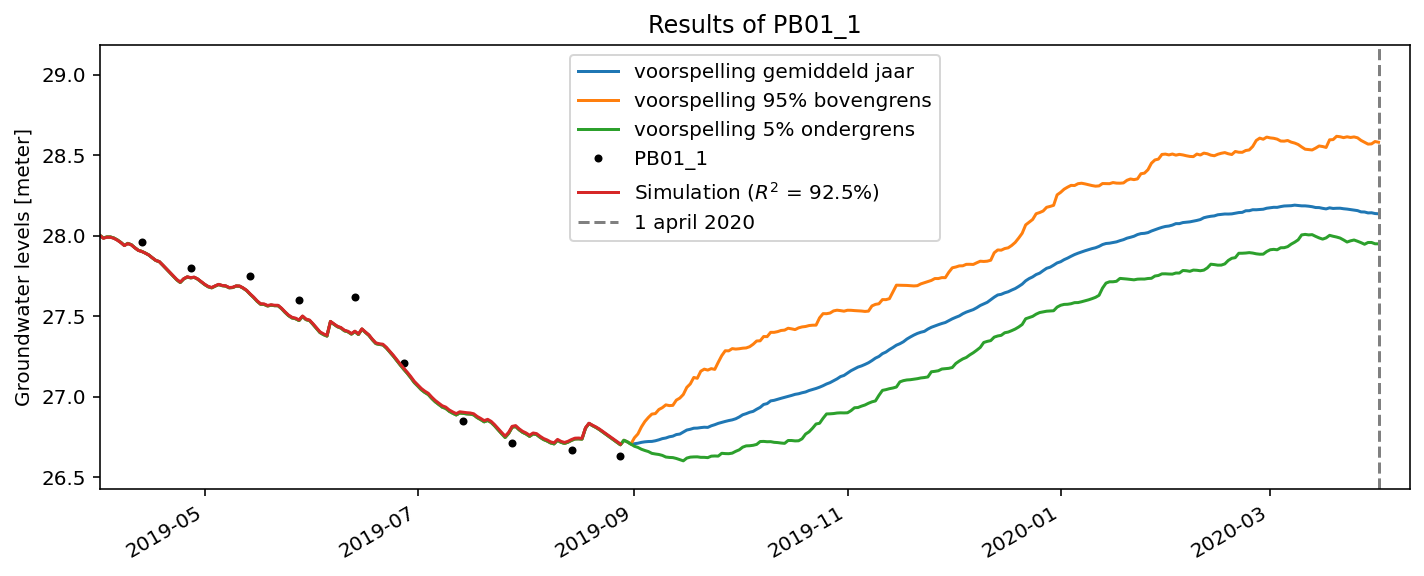

In [27]:
# opzetten model
ml_sim = ml.copy()

fig, ax = plt.subplots(figsize=(10, 4))

gemiddelde.index = pd.date_range('2019-09-01', '2020-03-31')
gemiddelde_stress = neerslag[:'2019-08-31'] + \
    fac_verdamping * verdamping[:'2019-08-31']
gemiddelde_stress = gemiddelde_stress['head'].append(
    gemiddelde.diff().fillna(gemiddelde))

ml_sim.del_stressmodel('gwa')
sm_sim = ps.StressModel(stress=gemiddelde_stress,
                        rfunc=ps.Exponential,
                        name='gwa',
                        settings='prec')
ml_sim.add_stressmodel(sm_sim)
ml_sim.parameters.loc['gwa_a',
                      'optimal'] = ml.parameters.loc['gwa_a', 'optimal']
ml_sim.parameters.loc['gwa_A',
                      'optimal'] = ml.parameters.loc['gwa_A', 'optimal']

gemiddelde_sim = ml_sim.simulate(tmax='2020-04-01')
ax.plot(gemiddelde_sim, label='voorspelling gemiddeld jaar')

bovengrens.index = pd.date_range('2019-09-01', '2020-03-31')
bovengrens_stress = neerslag[:'2019-08-31'] + \
    fac_verdamping * verdamping[:'2019-08-31']
bovengrens_stress = bovengrens_stress['head'].append(
    bovengrens.diff().fillna(bovengrens))

ml_sim.del_stressmodel('gwa')
sm_sim = ps.StressModel(stress=bovengrens_stress,
                        rfunc=ps.Exponential,
                        name='gwa',
                        settings='prec')
ml_sim.add_stressmodel(sm_sim)
ml_sim.parameters.loc['gwa_a',
                      'optimal'] = ml.parameters.loc['gwa_a', 'optimal']
ml_sim.parameters.loc['gwa_A',
                      'optimal'] = ml.parameters.loc['gwa_A', 'optimal']

bovengrens_sim = ml_sim.simulate(tmax='2020-04-01')
ax.plot(bovengrens_sim, label='voorspelling 95% bovengrens')

ondergrens.index = pd.date_range('2019-09-01', '2020-03-31')
ondergrens_stress = neerslag[:'2019-08-31'] + \
    fac_verdamping * verdamping[:'2019-08-31']
ondergrens_stress = ondergrens_stress['head'].append(
    ondergrens.diff().fillna(ondergrens))

ml_sim.del_stressmodel('gwa')
sm_sim = ps.StressModel(stress=ondergrens_stress,
                        rfunc=ps.Exponential,
                        name='gwa',
                        settings='prec')
ml_sim.add_stressmodel(sm_sim)
ml_sim.parameters.loc['gwa_a',
                      'optimal'] = ml.parameters.loc['gwa_a', 'optimal']
ml_sim.parameters.loc['gwa_A',
                      'optimal'] = ml.parameters.loc['gwa_A', 'optimal']

ondergrens_sim = ml_sim.simulate(tmax='2020-04-01')
ax.plot(ondergrens_sim, label='voorspelling 5% ondergrens')

ml.plot(ax=ax)
ax.axvline('2020-04-01', color='gray', ls='--', label='1 april 2020')
ax.legend()
ax.set_xlim(xmin=pd.Timestamp('2019-04-01'), xmax=pd.Timestamp('2020-04-10'));

Na 1 april 2020 wordt door het waterschap de meest recente data van peilbuis PB01 verzameld. Deze kunnen worden vergeleken met de voorspelling gemaakt in september. In de onderstaande afbeelding zijn de daadwerkelijk gemeten stijghoogtes samen met de voorspelling weergegeven. 

De daadwerkelijk gemeten stijghoogte in de periode september-oktober ligt lager dan het gemiddelde scenario. In de periode vanaf maart 2020 is de gemeten stijghoogte hoger dat het gemiddelde scenario. In het algemeen vallen de metingen binnen de bandbreedte van de 3 scenario's.


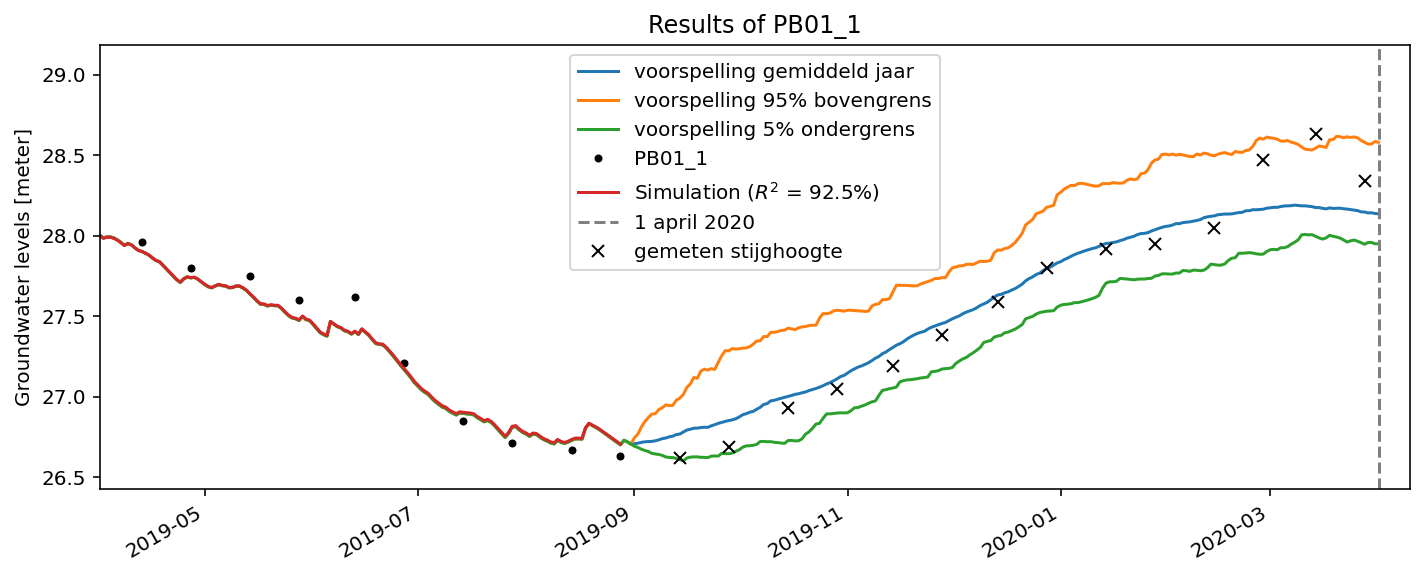

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(gemiddelde_sim, label='voorspelling gemiddeld jaar')
ax.plot(bovengrens_sim, label='voorspelling 95% bovengrens')
ax.plot(ondergrens_sim, label='voorspelling 5% ondergrens')
ml.plot(ax=ax)
ax.axvline('2020-04-01', color='gray', ls='--', label='1 april 2020')
ax.plot(gws['2019-09-01':'2020-04-10'], marker='x',
        ls='', color='k', label='gemeten stijghoogte')
ax.legend()
ax.set_xlim(xmin=pd.Timestamp('2019-04-01'), xmax=pd.Timestamp('2020-04-10'));

In de onderstaande figuur is voor de periode september 2019 - april 2020 het neerslagoverschot vergeleken met de neerslagoverschotten van de overige jaren. Dit neerslag overschot is op dezelfde manier bepaald als voor de overige jaren. Hierbij is te zien dat voor dit jaar in september-oktober het overschot lager is dan gemiddeld en in de period maart-april hoger. Dit beeld komt overeen met de vergelijking tussen de metingen en de 3 scenario's. 

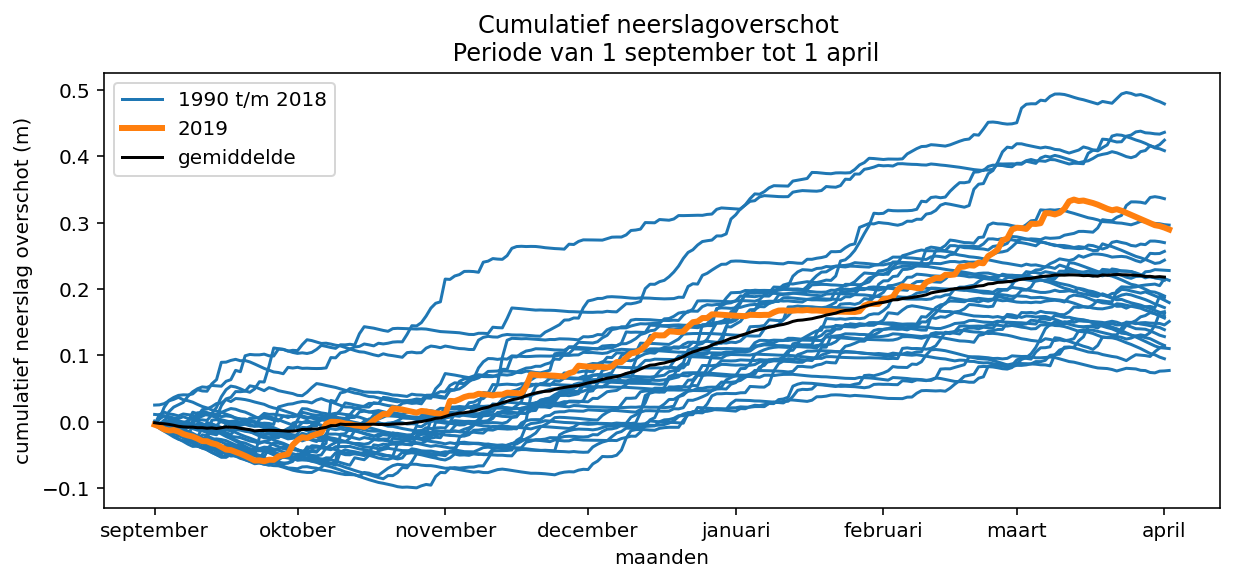

In [29]:
plt.figure(figsize=(10, 4))

fac_verdamping = ml.parameters.loc['gwa_f', 'optimal']
for year in range(1990, 2020, 1):
    y = (neerslag[f'{year}-09-01':f'{year+1}-04-01'] +
         fac_verdamping * verdamping[f'{year}-09-01':f'{year+1}-04-01'])
    y = y.cumsum()
    x = np.arange(len(y))

    if year == 1990:
        plt.plot(x, y, color='C0', label='1990 t/m 2018')
        dt_max = y.idxmax() - datetime.datetime(year, 9, 1)
    elif year == 2019:
        plt.plot(x, y, color='C1', label='2019', lw=3)
        dt_max = y.idxmax() - datetime.datetime(year, 9, 1)
    else:
        plt.plot(x, y, color='C0')
        dt_max = y.idxmax() - datetime.datetime(year, 9, 1)
    y.columns = [str(year)]
    y.index = y.index.month.astype(str) + '-' + y.index.day.astype(str)
    overschot = pd.concat([overschot, y], axis=1)

# plt.fill_between(x=x, y1=ondergrens.values, y2=bovengrens.values, 
#                  color='gray', alpha=0.3, label='90% zekerheidsinterval')
plt.plot(x[:-1], gemiddelde, color='k', label='gemiddelde')
plt.xlabel('maanden')
plt.ylabel('cumulatief neerslag overschot (m)')
plt.legend()
plt.title('Cumulatief neerslagoverschot \n Periode van 1 september tot 1 april')
plt.xticks(np.cumsum([0, 30, 31, 30, 31, 31, 28, 31]),
           labels=['september', 'oktober', 'november', 'december', 'januari',
                   'februari', 'maart', 'april']);